In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
class_name = 'TRACK_genre_top_num'
df = pd.read_csv('flat_df_no_nulli_no_out.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli
df['TRACK_genre_top_num'] = [1 if genre == "Rock" else 0 for genre in df["TRACK_genre_top"]]

df

,track_id,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,...,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_,TRACK_genre_top_num
0,2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America,0
1,3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,1.221668,0.087193,-0.092808,-0.029543,0.014404,0.106603,-0.251621,-0.060280,North America,0
2,5,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,...,1.546327,3.707580,-0.159586,0.005594,-0.004815,0.052547,-0.209312,-0.052692,North America,0
3,10,2008.0,4.0,Album,[],2.0,47632.0,Constant Hitmaker,small,4.317488,...,1.987875,1.841458,-0.089548,-0.084626,0.077173,-0.015011,-0.360596,-0.026267,NaN,0
9,134,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,...,2.088149,6.580380,-0.146649,-0.041780,0.039949,0.023004,-1.213183,-0.056095,North America,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104466,155315,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.896165,-1.260438,-0.059327,0.022795,-0.011546,0.097424,0.618452,0.003335,North America,1
104467,155316,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-1.297131,-0.902569,-0.010471,0.090281,-0.104228,-0.123058,0.233260,0.021846,North America,1
104468,155317,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,0.528187,-1.008135,0.155377,-0.135316,0.154183,-0.131252,-0.439485,0.051446,North America,1
104469,155318,2017.0,0.0,Live Performance,[],6.0,1506.0,"Live at Monty Hall, 2/17/2017",large,0.000000,...,-0.882132,-0.492957,0.030095,0.042125,-0.049494,-0.081322,-0.305773,-0.001345,North America,1


In [3]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop',
    'ALBUM_type_',
    'track_id'
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [4]:
compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [17]:
attributi = [
    "mfccskew",
    "mfccmedian",
    #"ALBUM_type_",
    "spectral_bandwidthmean01",
    "chroma_stftmedian",
    "mfccmax",
    "zcrstd01",
    "rmsekurtosis01",
    "ARTIST_favorites_",
    "spectral_centroidstd01",
    "ALBUM_date_released_year_",
    "zcrmedian01",
    "spectral_contrastmin",
    "chroma_cqtstd"
]

In [18]:
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

X = df[attributi].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [19]:
y = df[class_name]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [21]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

C:\Users\cri98\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=29), k=None,
                 timings=False)

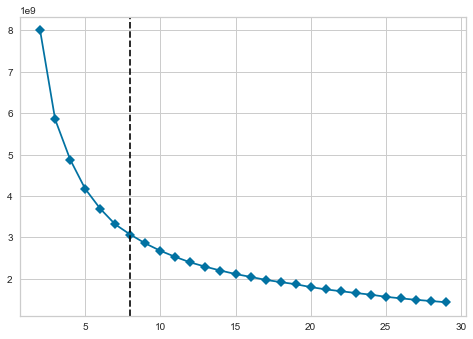

In [23]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X.squeeze())

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ", metric="silhouette")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X.squeeze())

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X_scaled.squeeze())

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ", metric="silhouette")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X_scaled.squeeze())

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X_rus.squeeze())

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25), timings=False, locate_elbow=True, title=" ", metric="silhouette")

#Automatically find the “elbow” or “knee” which likely corresponds to the optimal value of k
#using the “knee point detection algorithm”. 
visualizer.fit(X_rus.squeeze())

# GaussianMixture

In [36]:
from sklearn.mixture import GaussianMixture

covariance_type

- 'full': each component has its own general covariance matrix
- 'tied': all components share the same general covariance matrix
- 'diag': each component has its own diagonal covariance matrix
- 'spherical': each component has its own single variance

In [38]:
gm = GaussianMixture(n_components=10, random_state=0, covariance_type='spherical')
gm.fit(X_train)

y_pred = gm.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))

Accuracy 0.08672123384969221
F1-score [0.10195531 0.04646251 0.07925801 0.18770634 0.05274847 0.00553506
 0.06988353 0.01057579 0.02089552 0.        ]


In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {'n_components': range(1, 10),
              'covariance_type': ['full', 'tied', 'diag', 'spherical']
             }

clf = GaussianMixture()


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=10)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

GridSearchCV(cv=10, estimator=GaussianMixture(), n_jobs=-1,
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'n_components': range(1, 10)},
             scoring='accuracy', verbose=10)

In [80]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.100 (std: 0.039)
Parameters: {'covariance_type': 'tied', 'n_components': 9}

Model with rank: 2
Mean validation score: 0.093 (std: 0.036)
Parameters: {'covariance_type': 'spherical', 'n_components': 9}

Model with rank: 3
Mean validation score: 0.091 (std: 0.038)
Parameters: {'covariance_type': 'tied', 'n_components': 7}

Model with rank: 4
Mean validation score: 0.091 (std: 0.029)
Parameters: {'covariance_type': 'spherical', 'n_components': 6}

Model with rank: 5
Mean validation score: 0.089 (std: 0.045)
Parameters: {'covariance_type': 'spherical', 'n_components': 8}

Model with rank: 6
Mean validation score: 0.088 (std: 0.041)
Parameters: {'covariance_type': 'spherical', 'n_components': 5}

Model with rank: 7
Mean validation score: 0.086 (std: 0.044)
Parameters: {'covariance_type': 'full', 'n_components': 7}

Model with rank: 8
Mean validation score: 0.085 (std: 0.038)
Parameters: {'covariance_type': 'full', 'n_components': 9}

Model with r

# X-means

In [81]:
from pyclustering.cluster import xmeans

In [82]:
xm = xmeans.xmeans(X)
xm.process()

In [83]:
clusters = xm.get_clusters()
centers = xm.get_centers()

len(centers)

20

In [84]:
from pyclustering.cluster.silhouette import silhouette

ris = silhouette(X, clusters).process().get_score()
somma =.0

for i in ris:
    if(str(i) == "nan") :
        continue
    somma = somma + i
    
    
somma/len(ris)

0.7747537944935687

In [85]:
xm.get_total_wce()

220252968903.63156

# OPTICS

In [60]:
from sklearn.cluster import OPTICS

In [62]:
optics = OPTICS(min_samples=5, max_eps=np.inf, n_jobs=22)
optics.fit(X_rus)

OPTICS(n_jobs=22)

In [63]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_rus, optics.labels_))

Silhouette Coefficient: -0.531


In [95]:
min_s = range(110, 140, 5) # 125 --> 0.9812072665572572

ris = {}

for i in tqdm(min_s):
    optics = OPTICS(min_samples=i, max_eps=np.inf, n_jobs=22)
    optics.fit(X_rus)
    
    ris[i] = metrics.silhouette_score(X_rus, optics.labels_)
    
ris

{110: 0.981053283394671,
 115: 0.981053283394671,
 120: 0.9811008605718742,
 125: 0.9812072665572572,
 130: 0.9812072665572572,
 135: 0.9812072665572572}

### --------------------------------------------------------------------------------------------------------------------

# PARTE 4.3

# K-modes

In [16]:
from kmodes.kmodes import KModes

In [18]:
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(X)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11926, cost: 379135.0
Run 1, iteration: 2/100, moves: 2613, cost: 379135.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16720, cost: 379458.0
Run 2, iteration: 2/100, moves: 6, cost: 379458.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8172, cost: 379226.0
Run 3, iteration: 2/100, moves: 9, cost: 379226.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13168, cost: 378589.0
Run 4, iteration: 2/100, moves: 4, cost: 378589.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4942, cost: 386976.0
Run 5, iteration: 2/100, moves: 0, cost: 386976.0
Best run was number 4


# Rock

In [ ]:
from pyclustering.cluster import rock 

rc = rock.rock(X2[:100], eps=0.7, number_clusters=4, threshold=0.5)
rc.process()

In [ ]:
clusters = rc.get_clusters()